In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.colors import SymLogNorm
from scipy.signal import medfilt
from astropy import constants as const

In [2]:
f_rest = 1420405751.7667  # rest frequency in Hz
path_base = '/data4/beards/CHART_data/'
paths = [path_base + rest for rest in ['2019-07-31/', '2019-08-05/data_lost_dutchman_v1/',
                                       '2019-08-05/data_lost_dutchman_v2/', '2019-08-23_LNA_filter_LNA/',
                                       '2019-08-23_LNA_filter_LNA/ground/', '2019-08-23_LNA_FMfilter_LNA/']]

In [11]:
i = 2
path = paths[i]
data_files = sorted(glob.glob(path + '*dat'))
meta_files = sorted(glob.glob(path + '*metadata.npz'))
amp_files = sorted(glob.glob(path + 'terminator/*dat'))
meta_amp_files = sorted(glob.glob(path + 'terminator/*npz'))

meta = np.load(meta_files[0])
data = np.fromfile(data_files[0], dtype=np.float32)
data = data.reshape(data.size // int(meta['vector_length']), int(meta['vector_length']))

In [15]:
print(meta.files)

['int_length', 'samp_rate', 'data_file', 'start_time', 'times', 'frequency', 'end_time', 'date', 'vector_length', 'metadata_file']


<IPython.core.display.Javascript object>


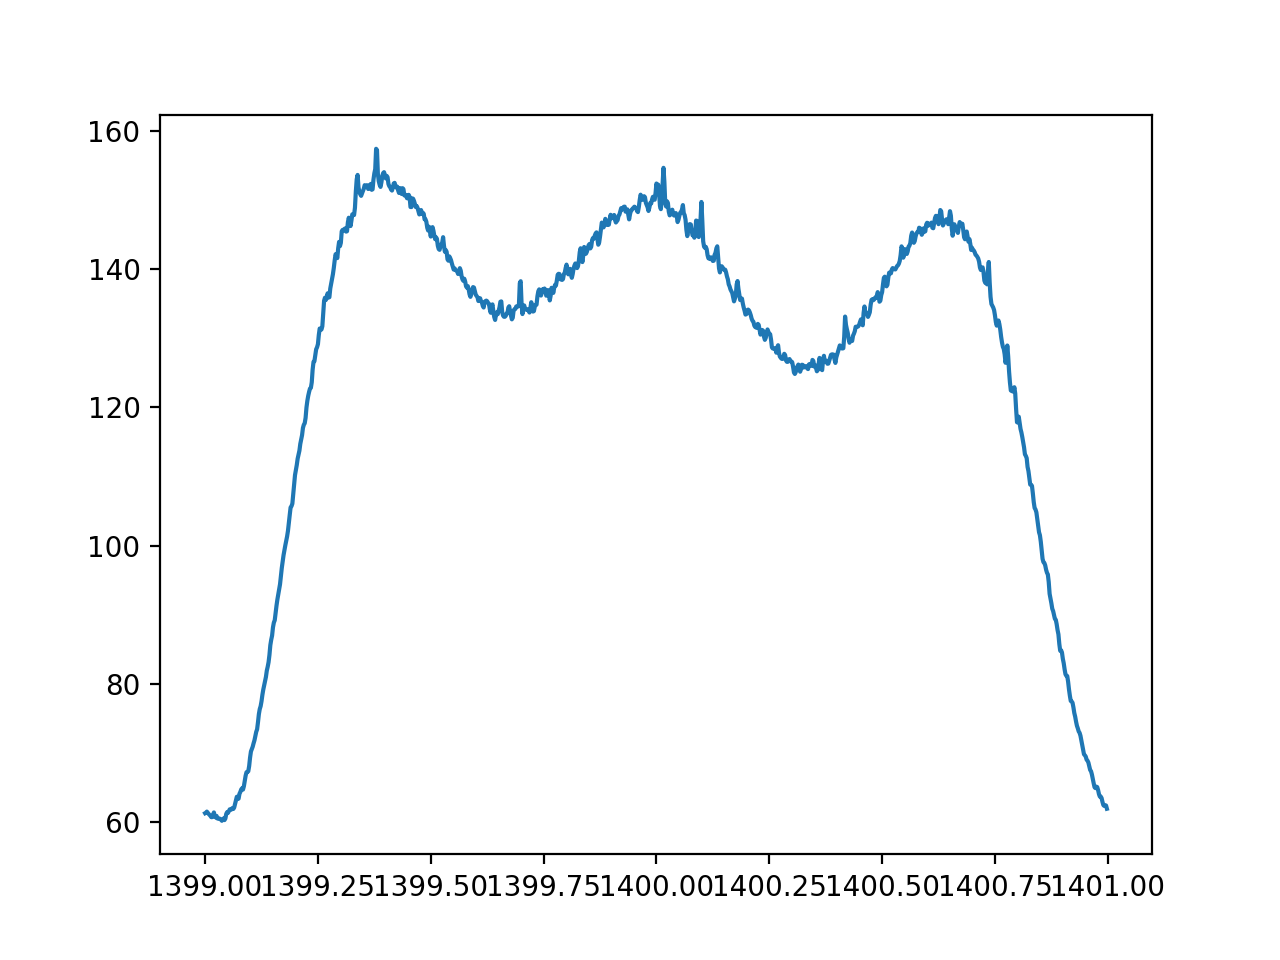

In [18]:
plt.figure()
freqs = ((np.arange(meta['vector_length']) - meta['vector_length'] / 2)
                 * meta['samp_rate'] / meta['vector_length'] + meta['frequency'])
plt.plot(1e-6 * freqs, np.mean(data, axis=0))

In [24]:
# Plot frequencies vs time
freqs = []
times = []
spectrum = []

for meta_file, data_file in zip(meta_files, data_files):
    meta = np.load(meta_file)
    freqs.append((np.arange(meta['vector_length']) - meta['vector_length'] / 2)
                 * meta['samp_rate'] // meta['vector_length'] + meta['frequency'])
    times.append(np.ones(meta['vector_length']) * np.mean(meta['times']))
    data = np.fromfile(data_file, dtype=np.float32)
    data = data.reshape(data.size // meta['vector_length'], meta['vector_length'])
    spectrum.append(np.mean(data, axis=0))
    spectrum[-1][meta['vector_length'] // 2 - 1:meta['vector_length'] // 2 + 2] = np.nan
    
afreqs = []
atimes = []
aspectrum = []

for meta_file, data_file in zip(meta_amp_files, amp_files):
    meta = np.load(meta_file)
    afreqs.append((np.arange(meta['vector_length']) - meta['vector_length'] / 2)
                  * meta['samp_rate'] / meta['vector_length'] + meta['frequency'])
    atimes.append(np.ones(meta['vector_length']) * np.mean(meta['times']))
    data = np.fromfile(data_file, dtype=np.float32)
    data = data.reshape(data.size // meta['vector_length'], meta['vector_length'])
    aspectrum.append(np.mean(data, axis=0))
    aspectrum[-1][meta['vector_length'] // 2 - 1:meta['vector_length'] // 2 + 2] = np.nan
    


<IPython.core.display.Javascript object>


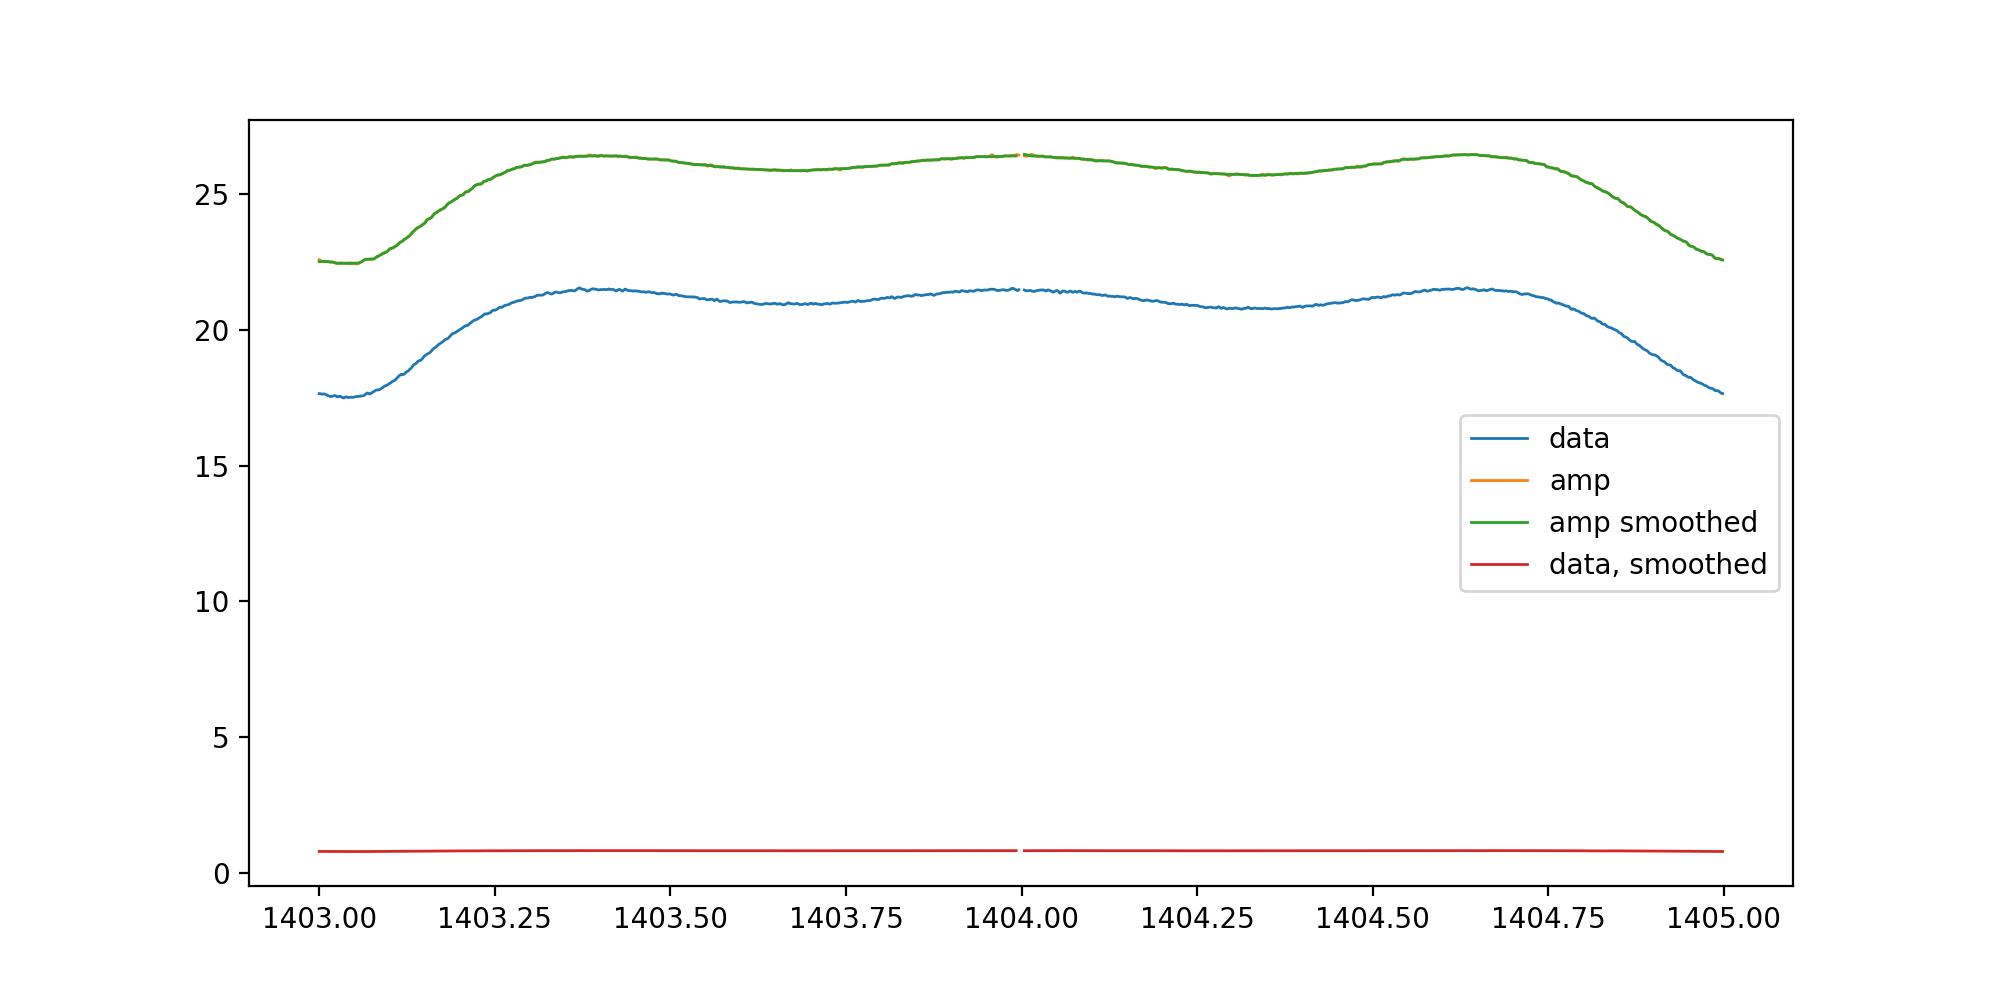

In [25]:
plt.figure()
i = 4
plt.plot(1e-6 * freqs[i], 10 * np.log10(spectrum[i]), linewidth=1, label='data')
# plt.plot(1e-6 * freqs[i], 10 * np.log10(cspectrum[i]), linewidth=1, label='cable')
plt.plot(1e-6 * freqs[i], 10 * np.log10(aspectrum[i]), linewidth=1, label='amp')
plt.plot(1e-6 * freqs[i], medfilt(10 * np.log10(aspectrum[i]), 11), linewidth=1, label='amp smoothed')
plt.plot(1e-6 * freqs[i], 10 * np.log10(spectrum[i]) / medfilt(10 * np.log10(aspectrum[i]), 11),
         linewidth=1, label='data, smoothed')
plt.legend()

<IPython.core.display.Javascript object>


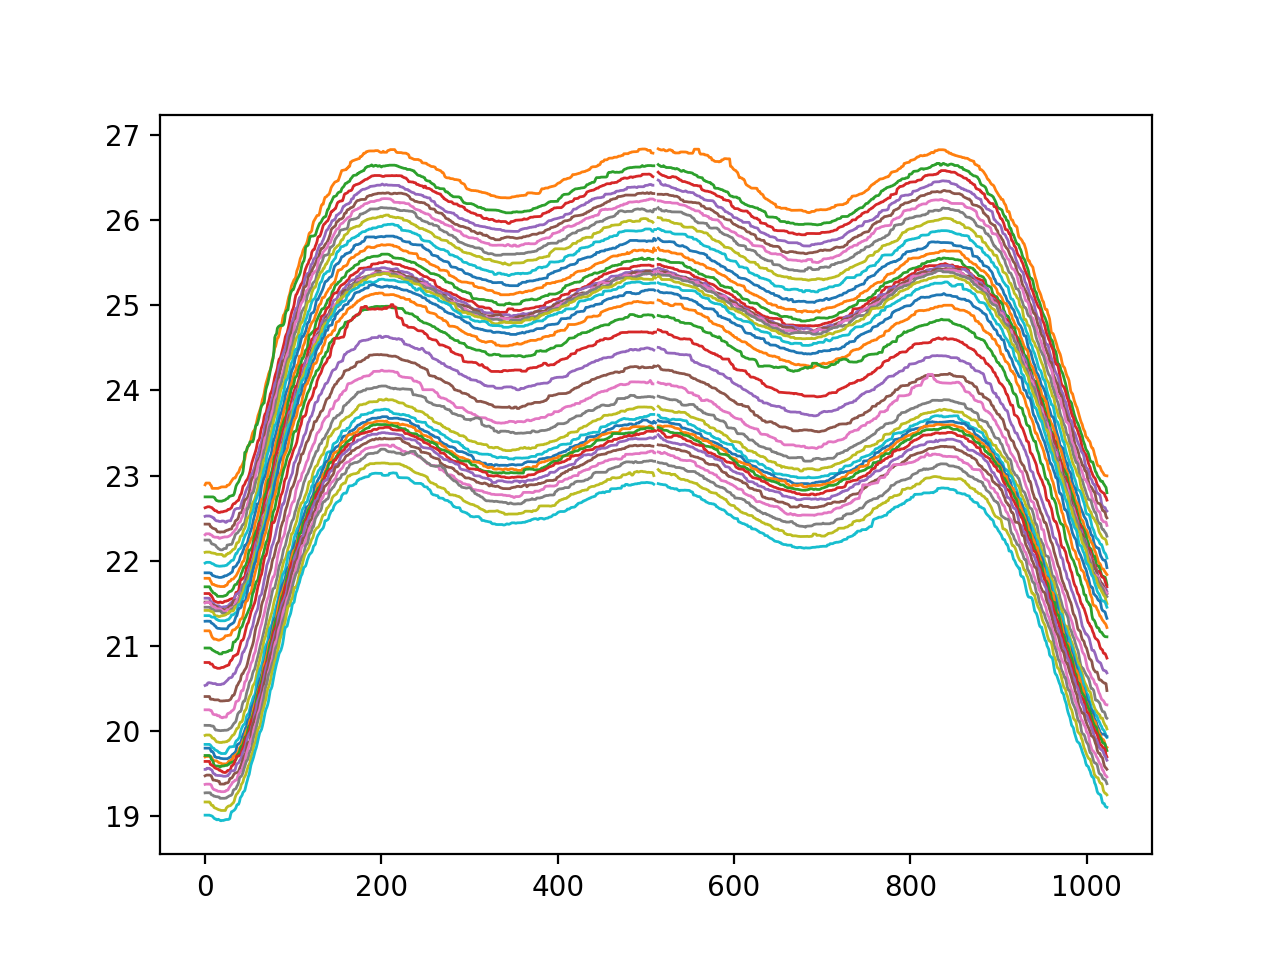

In [26]:
plt.figure()
for i in range(len(freqs)):
#     plt.plot(1e-6 * freqs[i], 10 * np.log10(spectrum[i]) / medfilt(10 * np.log10(aspectrum[i]), 11), linewidth=1)
#     plt.plot(1e-6 * freqs[i], 10 * np.log10(spectrum[i]), linewidth=1)
    plt.plot(medfilt(10 * np.log10(aspectrum[i]), 11), linewidth=1)
# plt.ylim([0, 6])
# plt.xlim([1419, 1421])

# Try for a more robust analysis

In [30]:
# Try to weight the data
freqs = []
for meta_file in meta_files:
    meta = np.load(meta_file)
    freqs += list((np.arange(meta['vector_length']) - meta['vector_length'] / 2)
                 * meta['samp_rate'] / meta['vector_length'] + meta['frequency'])
freqs = np.array(sorted(list(set(freqs))))
spectrum = np.zeros(len(freqs))
weights = np.zeros(len(freqs))

spec_start = meta['vector_length'] // 8
spec_stop = meta['vector_length'] * 7 // 8

for meta_file, data_file, amp_file in zip(meta_files, data_files, amp_files):
    meta = np.load(meta_file)
    fs = ((np.arange(meta['vector_length']) - meta['vector_length'] / 2)
          * meta['samp_rate'] / meta['vector_length'] + meta['frequency'])

    data = np.fromfile(data_file, dtype=np.float32)
    data = data.reshape(data.size // meta['vector_length'], meta['vector_length'])
    temp_spectrum = np.mean(data, axis=0)
    temp_spectrum[meta['vector_length'] // 2 - 1:meta['vector_length'] // 2 + 2] = np.nan

    data = np.fromfile(amp_file, dtype=np.float32)
    data = data.reshape(data.size // meta['vector_length'], meta['vector_length'])
    smooth = 10**(medfilt(10 * np.log10(np.mean(data, axis=0)), 11) / 10.)
    
    # Find the frequency channels
    ind0 = np.where(fs[0] == freqs)[0][0]
    spectrum[(ind0 + spec_start):(ind0 + spec_stop)] += temp_spectrum[spec_start:spec_stop]
    weights[(ind0 + spec_start):(ind0 + spec_stop)] += smooth[spec_start:spec_stop]
    
spectrum = 10 * np.log10(spectrum / weights)


/data4/beards/src/anaconda3/envs/hera/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


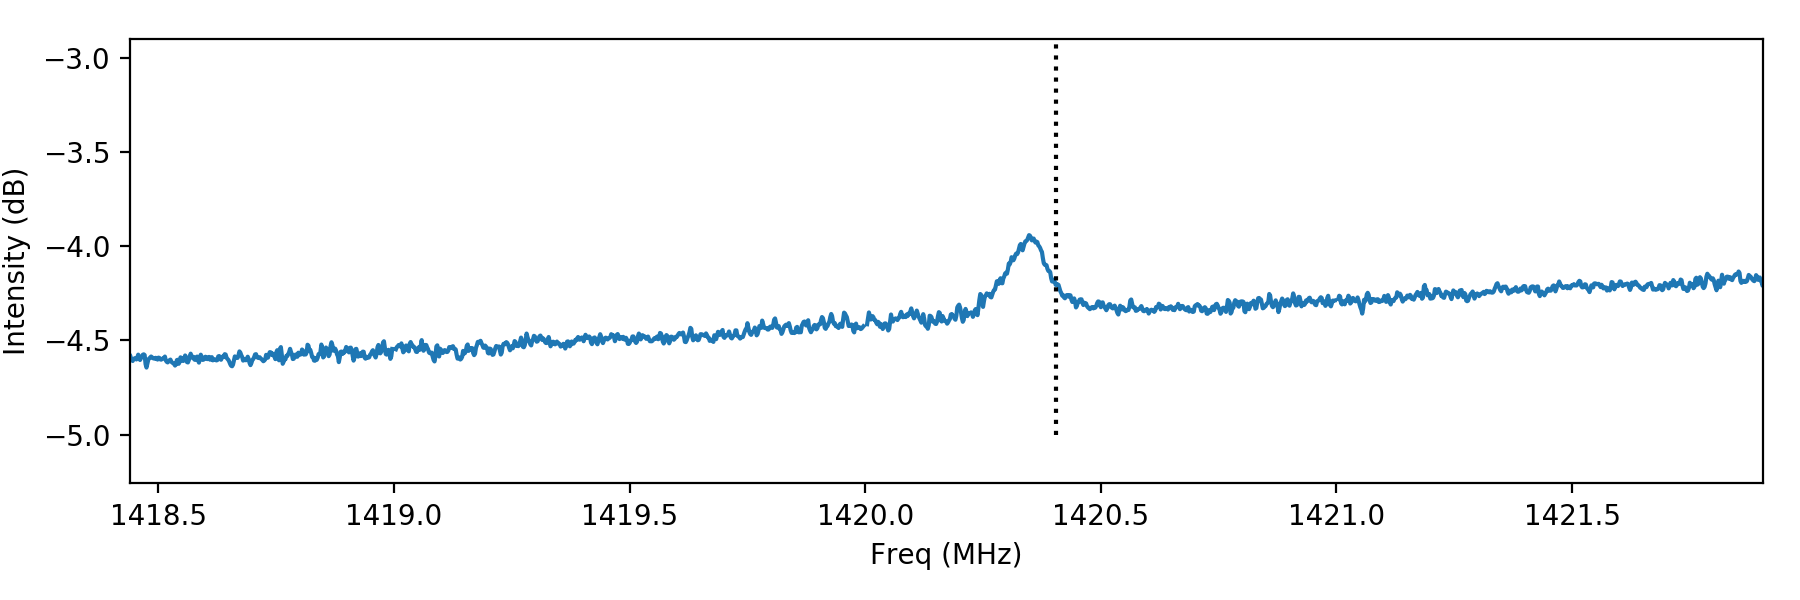

In [31]:
plt.figure(figsize=(9,3))
plt.plot(1e-6 * freqs, spectrum)
# plt.plot(1e-6 * freqs, 10**(spectrum / 10.))
plt.plot([1420405751.7667 * 1e-6, 1420405751.7667 * 1e-6], [-5, 0], ':k')
# plt.xlim([1419.5, 1421])
# plt.ylim([-4.6, -3.8])
plt.xlabel('Freq (MHz)')
plt.ylabel('Intensity (dB)')
plt.tight_layout()
plt.savefig('/home/beards/chart_21cm.png')

<IPython.core.display.Javascript object>


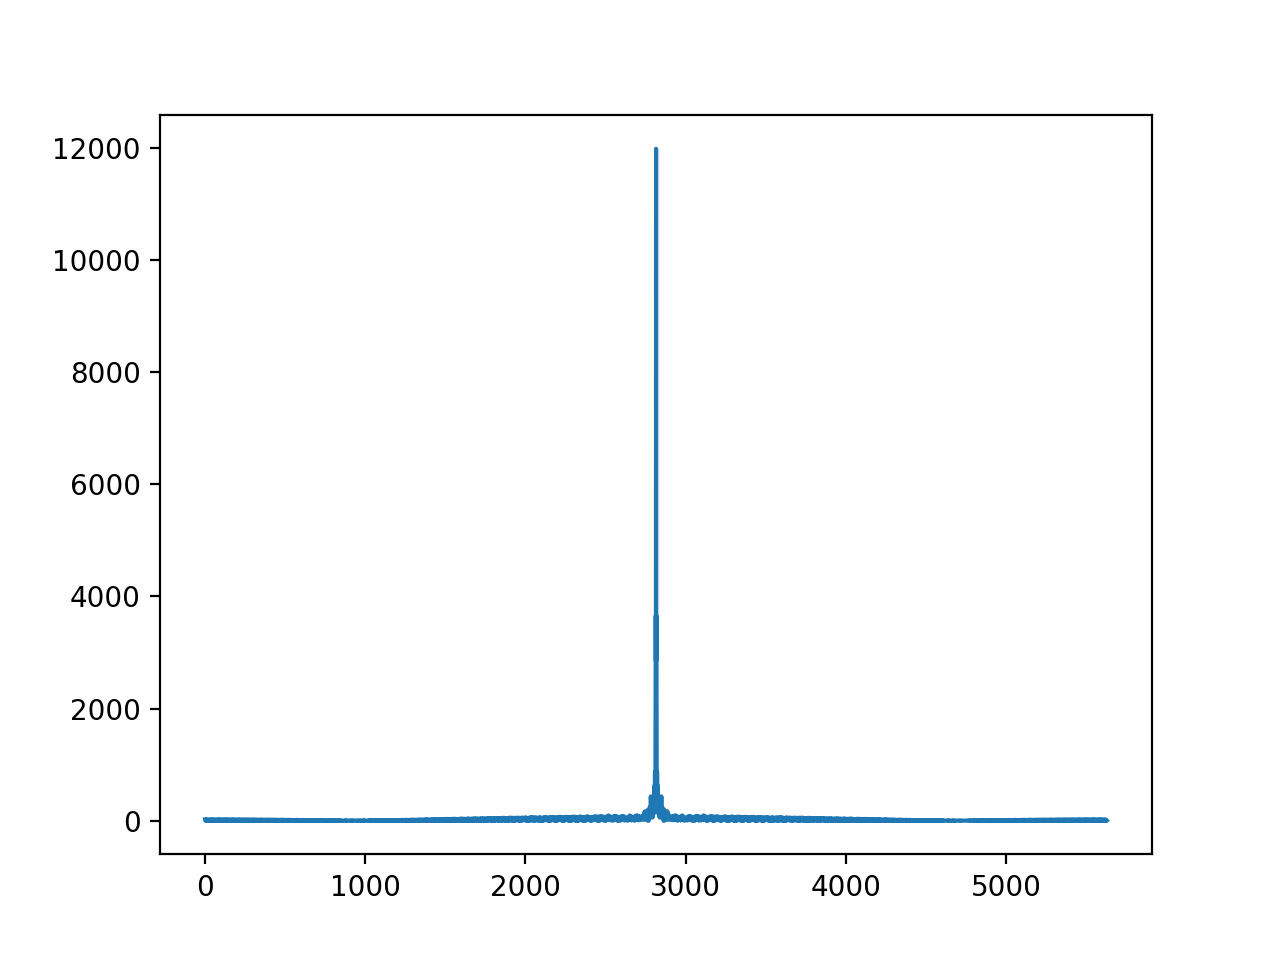

In [98]:
ma_spec = spectrum.copy()
ma_spec[~np.isfinite(spectrum)] = 0
fft_spec = np.fft.fftshift(np.fft.fft(ma_spec))
fft_spec[2082:2084] = 0
fft_spec[3549:3551] = 0
fft_spec[2863:2868] = 0
fft_spec[2765:2770] = 0
ma_spec = np.fft.ifft(np.fft.fftshift(fft_spec))
plt.figure()
plt.plot(np.abs(fft_spec))

<IPython.core.display.Javascript object>


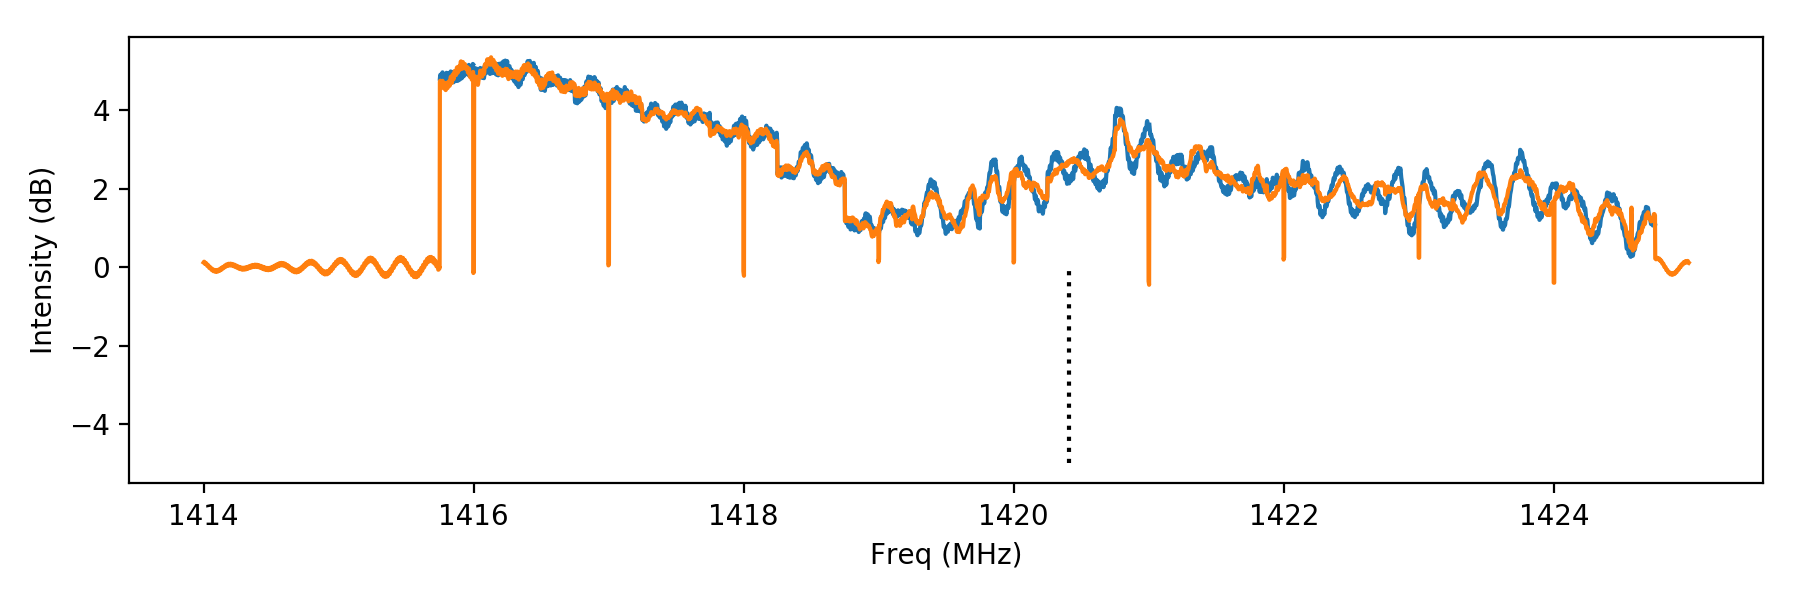

In [100]:
plt.figure(figsize=(9,3))
plt.plot(1e-6 * freqs, spectrum)
plt.plot(1e-6 * freqs, ma_spec)
# plt.plot(1e-6 * freqs, 10**(spectrum / 10.))
plt.plot([1420405751.7667 * 1e-6, 1420405751.7667 * 1e-6], [-5, 0], ':k')
# plt.xlim([1419.5, 1421])
# plt.ylim([-4.6, -3.8])
plt.xlabel('Freq (MHz)')
plt.ylabel('Intensity (dB)')
plt.tight_layout()
plt.savefig('/home/beards/chart_21cm.png')

<IPython.core.display.Javascript object>


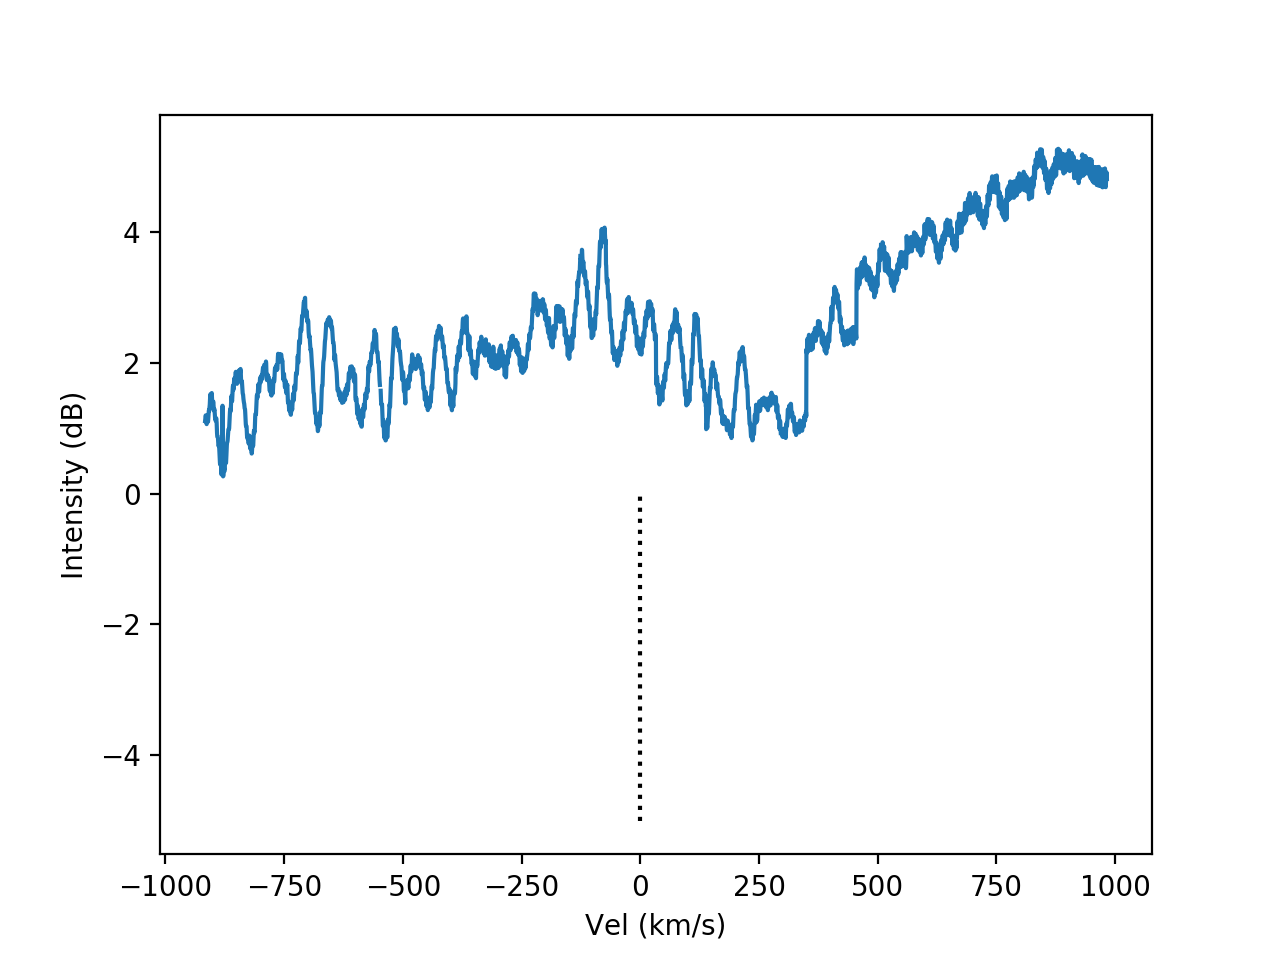

Text(0,0.5,'Intensity (dB)')

In [57]:
plt.figure()
vels = const.c * (f_rest - freqs) / f_rest * 1e-3

plt.plot(vels, spectrum)
# plt.plot(1e-6 * freqs, 10**(spectrum / 10.))
plt.plot([0, 0], [-5, 0], ':k')
# plt.xlim([1419, 1421])
# plt.ylim([-5, -3.5])
plt.xlabel('Vel (km/s)')
plt.ylabel('Intensity (dB)')

<IPython.core.display.Javascript object>


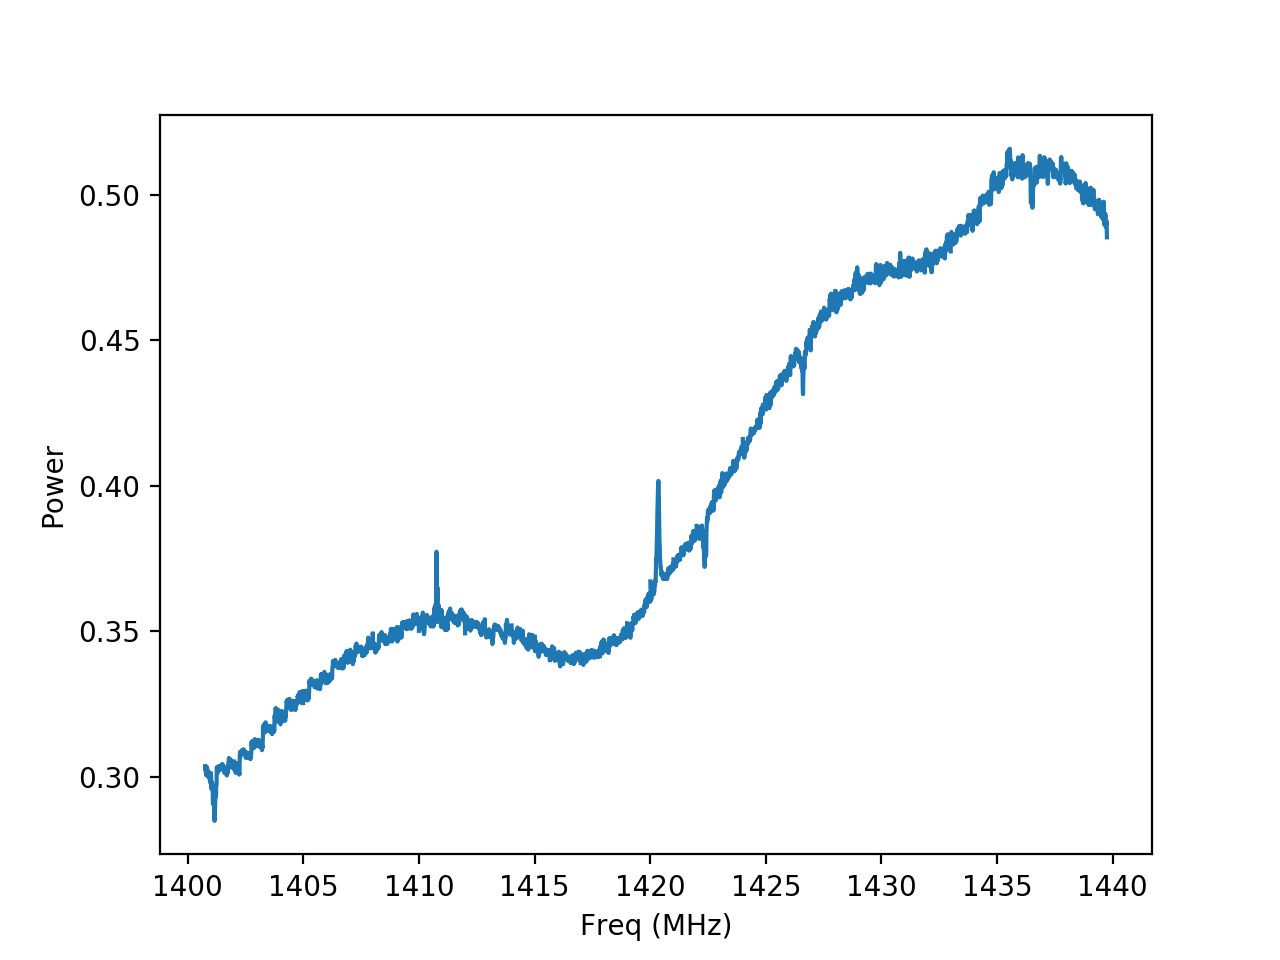

Text(0,0.5,'Power')

In [48]:
plt.figure()
plt.plot(1e-6 * freqs, 10**(medfilt(spectrum, 11)/10.))
# plt.xlim([1418.5, 1420.5])
# plt.xlim([1400, 1450])
plt.xlabel('Freq (MHz)')
plt.ylabel('Power')
# plt.ylim([-2, 3])